In [1]:
#LOAD REQUIRED LIBRARIES
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from datetime import datetime
import calendar
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster
import seaborn as sns
import matplotlib.cm as cm

DUE TO LOCAL ENVIOURNMENT SETUP PROBLEM WITH fancyImpute MODULE I AM USING SEPERATE PYTHON FILE FOR USING KNN.

In [2]:
# %load C:\Users\LENOVO\Anaconda3\Lib\site-packages\knn_impute.py
import numpy as np
import pandas as pd
from collections import defaultdict
from scipy.stats import hmean
from scipy.spatial.distance import cdist
from scipy import stats
import numbers


def weighted_hamming(data):
    """ Compute weighted hamming distance on categorical variables. For one variable, it is equal to 1 if
        the values between point A and point B are different, else it is equal the relative frequency of the
        distribution of the value across the variable. For multiple variables, the harmonic mean is computed
        up to a constant factor.

        @params:
            - data = a pandas data frame of categorical variables

        @returns:
            - distance_matrix = a distance matrix with pairwise distance for all attributes
    """
    categories_dist = []
    
    for category in data:
        X = pd.get_dummies(data[category])
        X_mean = X * X.mean()
        X_dot = X_mean.dot(X.transpose())
        X_np = np.asarray(X_dot.replace(0,1,inplace=False))
        categories_dist.append(X_np)
    categories_dist = np.array(categories_dist)
    distances = hmean(categories_dist, axis=0)
    return distances


def distance_matrix(data, numeric_distance = "euclidean", categorical_distance = "jaccard"):
    """ Compute the pairwise distance attribute by attribute in order to account for different variables type:
        - Continuous
        - Categorical
        For ordinal values, provide a numerical representation taking the order into account.
        Categorical variables are transformed into a set of binary ones.
        If both continuous and categorical distance are provided, a Gower-like distance is computed and the numeric
        variables are all normalized in the process.
        If there are missing values, the mean is computed for numerical attributes and the mode for categorical ones.
        
        Note: If weighted-hamming distance is chosen, the computation time increases a lot since it is not coded in C 
        like other distance metrics provided by scipy.

        @params:
            - data                  = pandas dataframe to compute distances on.
            - numeric_distances     = the metric to apply to continuous attributes.
                                      "euclidean" and "cityblock" available.
                                      Default = "euclidean"
            - categorical_distances = the metric to apply to binary attributes.
                                      "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                      available. Default = "jaccard"

        @returns:
            - the distance matrix
    """
    possible_continuous_distances = ["euclidean", "cityblock"]
    possible_binary_distances = ["euclidean", "jaccard", "hamming", "weighted-hamming"]
    number_of_variables = data.shape[1]
    number_of_observations = data.shape[0]

    # Get the type of each attribute (Numeric or categorical)
    is_numeric = [all(isinstance(n, numbers.Number) for n in data.iloc[:, i]) for i, x in enumerate(data)]
    is_all_numeric = sum(is_numeric) == len(is_numeric)
    is_all_categorical = sum(is_numeric) == 0
    is_mixed_type = not is_all_categorical and not is_all_numeric

    # Check the content of the distances parameter
    if numeric_distance not in possible_continuous_distances:
        print ("The continuous distance " + numeric_distance + " is not supported.")
        return None
    elif categorical_distance not in possible_binary_distances:
        print ("The binary distance " + categorical_distance + " is not supported.")
        return None

    # Separate the data frame into categorical and numeric attributes and normalize numeric data
    if is_mixed_type:
        number_of_numeric_var = sum(is_numeric)
        number_of_categorical_var = number_of_variables - number_of_numeric_var
        data_numeric = data.iloc[:, is_numeric]
        data_numeric = (data_numeric - data_numeric.mean()) / (data_numeric.max() - data_numeric.min())
        data_categorical = data.iloc[:, [not x for x in is_numeric]]

    # Replace missing values with column mean for numeric values and mode for categorical ones. With the mode, it
    # triggers a warning: "SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame"
    # but the value are properly replaced
    y=data
    if is_mixed_type:
        data_numeric.fillna(data_numeric.mean(), inplace=True)
        for x in data_categorical:
            data_categorical[x].fillna(data_categorical[x].mode()[0], inplace=True)
    elif is_all_numeric:
        y.fillna(y.mean(),axis = 'rows', inplace=True)
    else:
        for x in data:
            data[x].fillna(data[x].mode()[0], inplace=True)
    
    data=y
    # "Dummifies" categorical variables in place
    if not is_all_numeric and not (categorical_distance == 'hamming' or categorical_distance == 'weighted-hamming'):
        if is_mixed_type:
            data_categorical = pd.get_dummies(data_categorical)
        else:
            data = pd.get_dummies(data)
    elif not is_all_numeric and categorical_distance == 'hamming':
        if is_mixed_type:
            data_categorical = pd.DataFrame([pd.factorize(data_categorical[x])[0] for x in data_categorical]).transpose()
        else:
            data = pd.DataFrame([pd.factorize(data[x])[0] for x in data]).transpose()

    if is_all_numeric:
        result_matrix = cdist(data, data, metric=numeric_distance)
    elif is_all_categorical:
        if categorical_distance == "weighted-hamming":
            result_matrix = weighted_hamming(data)
        else:
            result_matrix = cdist(data, data, metric=categorical_distance)
    else:
        result_numeric = cdist(data_numeric, data_numeric, metric=numeric_distance)
        if categorical_distance == "weighted-hamming":
            result_categorical = weighted_hamming(data_categorical)
        else:
            result_categorical = cdist(data_categorical, data_categorical, metric=categorical_distance)
        result_matrix = np.array([[1.0*(result_numeric[i, j] * number_of_numeric_var + result_categorical[i, j] *
                               number_of_categorical_var) / number_of_variables for j in range(number_of_observations)] for i in range(number_of_observations)])

    # Fill the diagonal with NaN values
    np.fill_diagonal(result_matrix, np.nan)

    return pd.DataFrame(result_matrix)


def knn_impute(tar, attributes, k_neighbors, aggregation_method="median", numeric_distance="euclidean",
               categorical_distance="jaccard", missing_neighbors_threshold = 0.5):
    """ Replace the missing values within the target variable based on its k nearest neighbors identified with the
        attributes variables. If more than 50% of its neighbors are also missing values, the value is not modified and
        remains missing. If there is a problem in the parameters provided, returns None.
        If to many neighbors also have missing values, leave the missing value of interest unchanged.

        @params:
            - target                        = a vector of n values with missing values that you want to impute. The length has
                                              to be at least n = 3.
            - attributes                    = a data frame of attributes with n rows to match the target variable
            - k_neighbors                   = the number of neighbors to look at to impute the missing values. It has to be a
                                              value between 1 and n.
            - aggregation_method            = how to aggregate the values from the nearest neighbors (mean, median, mode)
                                              Default = "mean"
            - numeric_distances             = the metric to apply to continuous attributes.
                                              "euclidean" and "cityblock" available.
                                              Default = "euclidean"
            - categorical_distances         = the metric to apply to binary attributes.
                                              "jaccard", "hamming", "weighted-hamming" and "euclidean"
                                              available. Default = "jaccard"
            - missing_neighbors_threshold   = minimum of neighbors among the k ones that are not also missing to infer
                                              the correct value. Default = 0.5

        @returns:
            target_completed        = the vector of target values with missing value replaced. If there is a problem
                                      in the parameters, return None
    """

    # Get useful variables
    possible_aggregation_method = ["mean", "median", "mode"]
    number_observations = len(tar)
    is_target_numeric = all(isinstance(n, numbers.Number) for n in tar)

    # Check for possible errors
    if number_observations < 3:
        print ("Not enough observations.")
        return None
    if attributes.shape[0] != number_observations:
        print ("The number of observations in the attributes variable is not matching the target variable length.")
        return None
    if k_neighbors > number_observations or k_neighbors < 1:
        print ("The range of the number of neighbors is incorrect.")
        return None
    if aggregation_method not in possible_aggregation_method:
        print ("The aggregation method is incorrect.")
        return None
    if not is_target_numeric and aggregation_method != "mode":
        print ("The only method allowed for categorical target variable is the mode.")
        return None

    # Make sure the data are in the right format
    target = pd.DataFrame(tar)
    attributes = pd.DataFrame(attributes)

    # Get the distance matrix and check whether no error was triggered when computing it
    distances = distance_matrix(attributes, numeric_distance, categorical_distance)
    if distances is None:
        return None

    # Get the closest points and compute the correct aggregation method
    for i, value in enumerate(target.iloc[:, 0]):
        if pd.isnull(value):
            order = distances.iloc[i,:].values.argsort()[:k_neighbors]
            closest_to_target = target.iloc[order, :]
            missing_neighbors = [x for x  in closest_to_target.isnull().iloc[:, 0]]
            # Compute the right aggregation method if at least more than 50% of the closest neighbors are not missing
            if sum(missing_neighbors) >= missing_neighbors_threshold * k_neighbors:
                continue
            elif aggregation_method == "mean":
                target.iloc[i] = np.ma.mean(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            elif aggregation_method == "median":
                target.iloc[i] = np.ma.median(np.ma.masked_array(closest_to_target,np.isnan(closest_to_target)))
            else:
                target.iloc[i] = stats.mode(closest_to_target, nan_policy='omit')[0][0]

    return target


In [3]:
#SET WORKING DIRECTORY 
os.chdir("D:\DATA SCIENCE\COURSE\Projects\Project_Cab_Fare_Prediction")
#CHECK WORKING DIRECTORY  
os.getcwd()

'D:\\DATA SCIENCE\\COURSE\\Projects\\Project_Cab_Fare_Prediction'

In [4]:
#LOAD TRAIN AND TEST DATA
train=pd.read_csv("train_cab.csv")
test=pd.read_csv("test.csv")

In [5]:
#CHECK FOR MISSING VALUES
train.isna().sum()

fare_amount          24
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

In [6]:
#CHECK FOR VARIABLE DATA TYPES
train.dtypes

fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [7]:
#CHANGE REQUIRED DATA TYPES
#SOME VALUES MAY BE MISFORMATTED IN ORIGINAL DATA. ON CHANGING DATA TYPES THESE MISFORMATTED VALUES MAY CONVERT TO NA.
#AS THESE ARE MISFORMATTED VALUES THEY SHOULD BE TREATED AS MISSING VALUES.

#change datatype of fare_amount to float
train.fare_amount=pd.to_numeric(train.fare_amount,errors="coerce")

#convert pickup_datetime to datetime
train.pickup_datetime=pd.to_datetime(train.pickup_datetime,errors="coerce")
train.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
dtype: object

MISSING VALUE ANALYSIS

In [8]:
train.isna().sum()
#some values are misformatted and cannot properly converted in desired types and hence converted to NaN 
#these misformated values are very less and can be treated as NaN 

fare_amount          25
pickup_datetime       1
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64

In [9]:
#MISSING VALUE %
(train.isna().sum()/len(train))*100

fare_amount          0.155598
pickup_datetime      0.006224
pickup_longitude     0.000000
pickup_latitude      0.000000
dropoff_longitude    0.000000
dropoff_latitude     0.000000
passenger_count      0.342317
dtype: float64

In [10]:
#MISSING VALUE ANALYSIS FOR far_amount BECAUSE THIS IS OUR TARGET VARIABLE. WE SHOULD NOT LOOSE INFLUENTIAL INSTANCES BY REMOVING MISSING VALUES FROM THIS VARIABLE.
actual=train['fare_amount'].loc[41]#8.1
train['fare_amount'].loc[419]=np.nan
#TRY FOR MEAN IMPUTATION.
train['fare_amount'].mean()#15.0
#TRY FOR MEDIAN IMPUTATION
train['fare_amount'].median()#8.5
#TRY FOR KNN IMPUTATION
knn=knn_impute(train['fare_amount'],train.loc[:, train.columns != 'pickup_datetime'].copy(),7)
knn.loc[429]#32.9

C:\Users\LENOVO\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


fare_amount    32.9
Name: 429, dtype: float64

In [11]:
#AS WE CAN SEE MISSING VALUE IMPUTED BY median IS NEAREST TO ACTUAL VALUE HENCE WE WILL REPLACE MISSING VALUES WITH median.
train['fare_amount']=train['fare_amount'].replace(np.NaN,train['fare_amount'].median())

In [12]:
#DELETE MISSING VALUE OF pickup_datetime. NEED TO BE IMPUTED.
train.drop(train[train['pickup_datetime'].isna()].index,axis='rows',inplace=True)

#IMPUTE MISSING VALUES OF passenger_count WITH MEDIAN. MEAN AND KNN CAN GIVE DECIMAL RESULTS.
#HOWEVER IN FURTHER ANALYSIS WE WILL SEE THAT THIS VARIABLE WILL BE DELETED BEACAUSE OF ITS LESS IMPORTANCE IN OUR BUSINESSS GOAL.
train['passenger_count']=train['passenger_count'].replace(np.NaN,train['passenger_count'].median())


In [13]:
train.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [14]:
#OUTLIER ANALYSIS AND FEATURE EXTRACTION
#OUTLIER ANALYSIS IS NOT DONE WITH BOXPLOT METHOD.
#BECAUSE THIS WILL REMOVE IMPORTANT INSTANCES IN DATA.
#CONFINE THE LOCATION DATA OF train ACCORDING TO EXTREME LOCATIONS OF TEST DATA
#identifying city with latitutes and longitudes
minmax_longitudes=min(test.pickup_longitude.min(),test.dropoff_longitude.min()),max(test.pickup_longitude.max(),test.dropoff_longitude.max())
minmax_lattitudes=min(test.pickup_latitude.min(),test.dropoff_latitude.min()),max(test.pickup_latitude.max(),test.dropoff_latitude.max())
minmax_lattitudes,minmax_longitudes

((40.568973, 41.709555), (-74.263242, -72.986532))

In [15]:
#we use this function to select rows in train data which lies in given limit coordinates
def select_limited(df,BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

In [16]:
BOX=(minmax_longitudes[0],minmax_longitudes[1],minmax_lattitudes[0],minmax_lattitudes[1])
train=train[select_limited(train,BOX)]

In [17]:
train.shape

(15713, 7)

In [18]:
#SELECT NON NEGATIVE fare_amount
train=train[train['fare_amount']>=0]

In [19]:
#IDENTIFY CITY. 
#CALCULATE MEAN LOCATIONS FOR test DATA AND LOCATE CITY ON THESE MEAN COORDINATES.
test.pickup_longitude.mean(),test.pickup_latitude.mean()

(-73.97472222393064, 40.75104072348803)

In [20]:
#CITY IS NEW YORK. WE ARE GOING TO PREDICT TRIP AMOUNT FOR NEW YORK.
#train data gives us information about city. Our test data sholud also lie in this range 
#plotting locations on city map
city_map = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')
# this function will be used more often to plot data on the NEW YORK CITY map
def plot_on_map(df, BB, city_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(32,32))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(city_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(city_map, zorder=0, extent=BB)

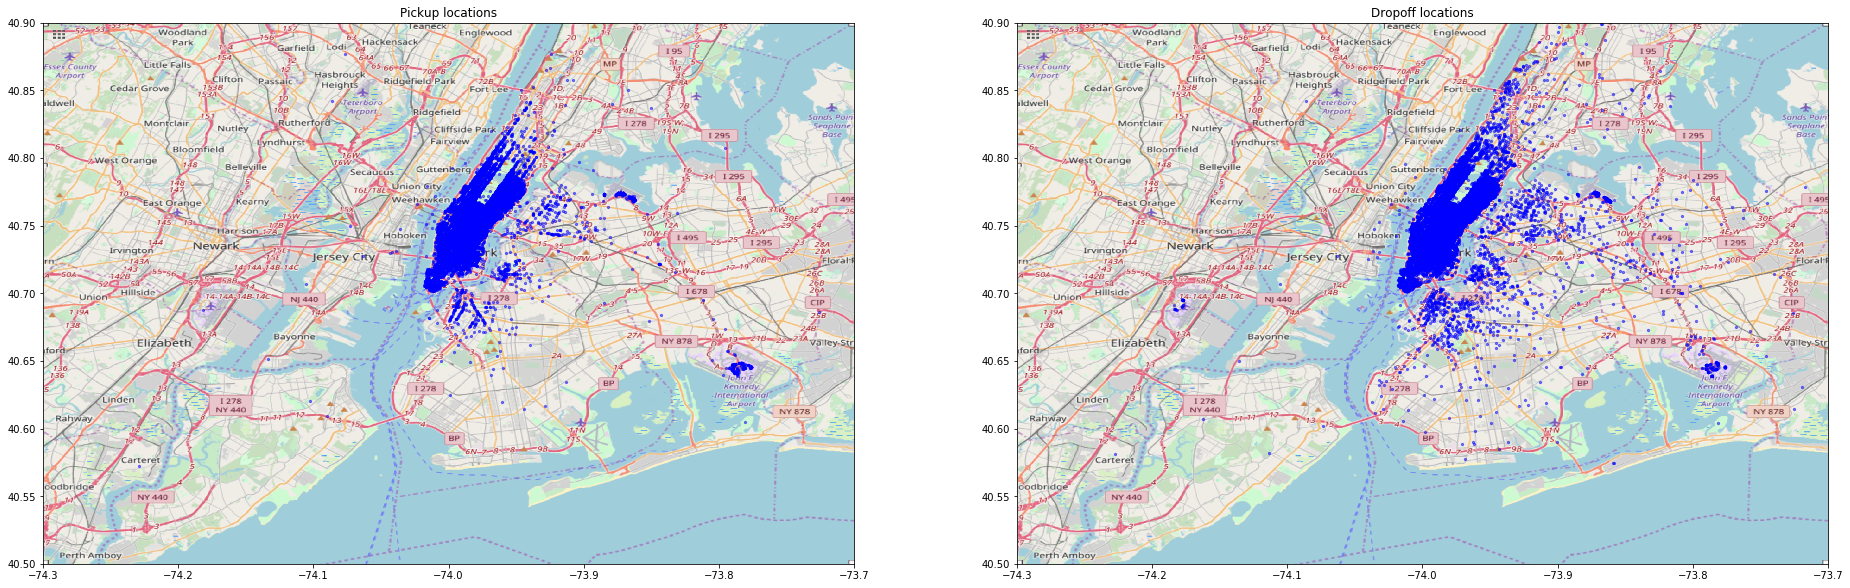

In [21]:
BOX_zoom = (-74.3, -73.7, 40.5, 40.9)
plot_on_map(train, BOX_zoom, city_map, s=5, alpha=0.5)

In [22]:
#EXTRACTING HOUR, DATE, MONTH, YEAR, DAYS OF WEEK, DAY
train['pickup_date']= train['pickup_datetime'].dt.date
train['pickup_day']=train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week']=train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train['pickup_month']=train['pickup_datetime'].apply(lambda x:x.month)
train['pickup_year']=train['pickup_datetime'].apply(lambda x:x.year)

In [23]:
#CALCULATING TRIP DISTANCE IN km.
#create a variable for distance of a trip
def distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 2 * R * np.arcsin(np.sqrt(a)) # 2*R*asin..

In [24]:
train['distance_km'] = distance(train.pickup_latitude, train.pickup_longitude,train.dropoff_latitude, train.dropoff_longitude)

In [25]:
BB = (-74.5, -72.8, 40.5, 41.8)
#density plot for locations        
# First calculate two arrays with datapoint density per sq mile
n_lon, n_lat = 200, 200 # number of grid bins per longitude, latitude dimension
density_pickup, density_dropoff = np.zeros((n_lat, n_lon)), np.zeros((n_lat, n_lon)) # prepare arrays

# To calculate the number of datapoints in a grid area, the numpy.digitize() function is used. 
# This function needs an array with the (location) bins for counting the number of datapoints
# per bin.
bins_lon = np.zeros(n_lon+1) # bin
bins_lat = np.zeros(n_lat+1) # bin
delta_lon = (BB[1]-BB[0]) / n_lon # bin longutide width
delta_lat = (BB[3]-BB[2]) / n_lat # bin latitude height
bin_width_miles = distance(BB[2], BB[1], BB[2], BB[0]) / n_lon # bin width in miles
bin_height_miles = distance(BB[3], BB[0], BB[2], BB[0]) / n_lat # bin height in miles
for i in range(n_lon+1):
    bins_lon[i] = BB[0] + i * delta_lon
for j in range(n_lat+1):
    bins_lat[j] = BB[2] + j * delta_lat
    
# Digitize per longitude, latitude dimension
inds_pickup_lon = np.digitize(train.pickup_longitude, bins_lon)
inds_pickup_lat = np.digitize(train.pickup_latitude, bins_lat)
inds_dropoff_lon = np.digitize(train.dropoff_longitude, bins_lon)
inds_dropoff_lat = np.digitize(train.dropoff_latitude, bins_lat)

# Count per grid bin
# note: as the density_pickup will be displayed as image, the first index is the y-direction, 
#       the second index is the x-direction. Also, the y-direction needs to be reversed for
#       properly displaying (therefore the (n_lat-j) term)
dxdy = bin_width_miles * bin_height_miles
for i in range(n_lon):
    for j in range(n_lat):
        density_pickup[j, i] = np.sum((inds_pickup_lon==i+1) & (inds_pickup_lat==(n_lat-j))) / dxdy
        density_dropoff[j, i] = np.sum((inds_dropoff_lon==i+1) & (inds_dropoff_lat==(n_lat-j))) / dxdy

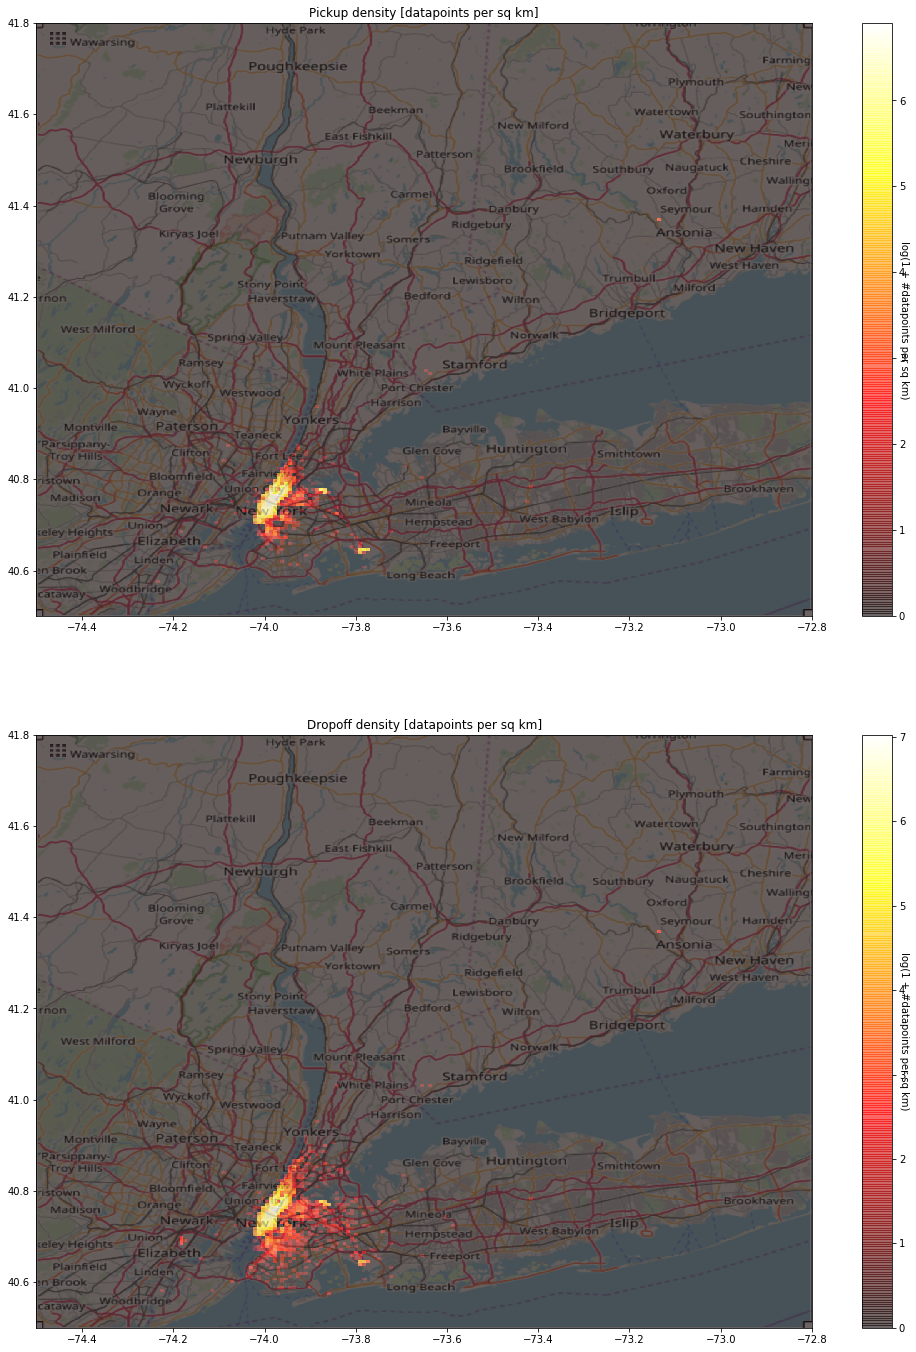

In [26]:

city_map_zoomout = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')
#density plot for pickup locations   
fig, axs = plt.subplots(2, 1, figsize=(18, 24))
axs[0].imshow(city_map_zoomout, zorder=0, extent=BB);
im = axs[0].imshow(np.log1p(density_pickup), zorder=1, extent=BB, alpha=0.6, cmap=cm.hot)
axs[0].set_title('Pickup density [datapoints per sq km]')
cbar = fig.colorbar(im, ax=axs[0])
cbar.set_label('log(1 + #datapoints per sq km)', rotation=270)

#density plot for dropoff locations
axs[1].imshow(city_map_zoomout, zorder=0, extent=BB);
im = axs[1].imshow(np.log1p(density_dropoff), zorder=1, extent=BB, alpha=0.6, cmap=cm.hot)
axs[1].set_title('Dropoff density [datapoints per sq km]')
cbar = fig.colorbar(im, ax=axs[1])
cbar.set_label('log(1 + #datapoints per sq km)', rotation=270)

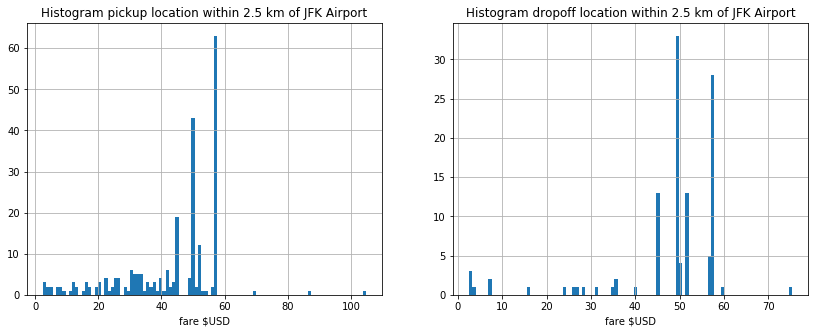

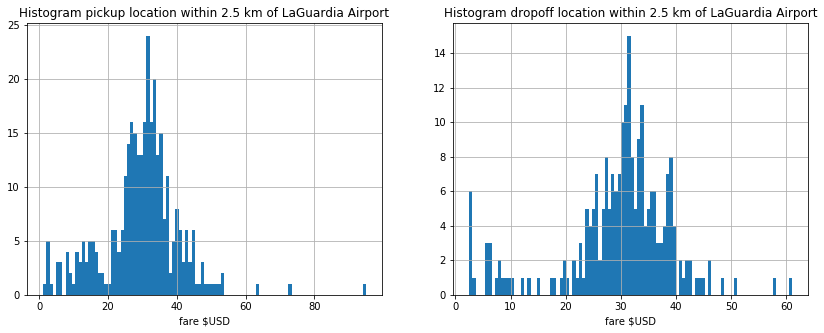

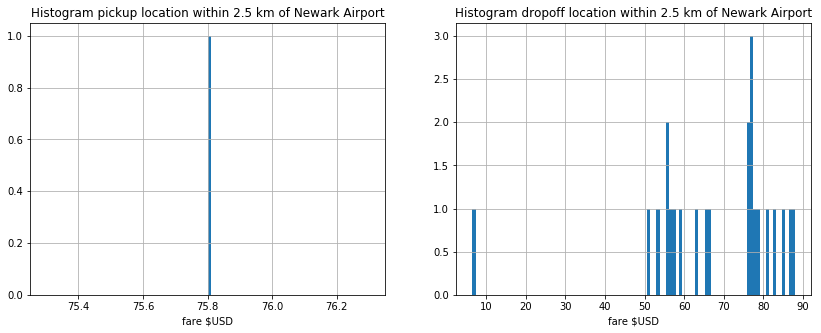

In [27]:
#CHECKING FOR AIRPORT RIDES
#3 MAIN AIRPORTS IN/NEAR NEW YORK CITY. JFK, LA GAURDIA, NEWARK.
#LOCATIONS FROM GOOGLE MAP.
jfk = (-73.7822222222, 40.6441666667)#JFK
nyc = (-74.0063889, 40.7141667)#NEW YORK CITY CENTER 
lgr = (-73.8719444444,40.7747222222)#LA GAURDIA 
ewr = (-74.175, 40.69)#NEWARK 
def plot_location_fare(loc, name, range=2.5):
    # select all datapoints with dropoff location within range of airport
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    idx = (distance(train.pickup_latitude, train.pickup_longitude, loc[1], loc[0]) < range)
    train[idx].fare_amount.hist(bins=100, ax=axs[0])
    axs[0].set_xlabel('fare $USD')
    axs[0].set_title('Histogram pickup location within {} km of {}'.format(range, name))

    idx = (distance(train.dropoff_latitude, train.dropoff_longitude, loc[1], loc[0]) < range)
    train[idx].fare_amount.hist(bins=100, ax=axs[1])
    axs[1].set_xlabel('fare $USD')
    axs[1].set_title('Histogram dropoff location within {} km of {}'.format(range, name));
    
plot_location_fare(jfk, 'JFK Airport')
plot_location_fare(lgr, 'LaGuardia Airport')
plot_location_fare(ewr,"Newark Airport")

In [28]:
#OBSERVING PLOTS WE CAN SAY THAT FARE FOR AIRPORT RIDES IS HIGHER AND GENERALLY FIXED.
#THIS CONFIRMS OUR HYPOTHESIS
def is_pickup_near_Airport(loc,range=2.5):
    return (distance(train.pickup_latitude, train.pickup_longitude, loc[1], loc[0]) < range)
    
def is_dropoff_near_Airport(loc,range=2.5):
    return (distance(train.dropoff_latitude, train.dropoff_longitude, loc[1], loc[0]) < range)
        

In [29]:
train['is_pickup_near_jfk']=is_pickup_near_Airport(jfk)
train['is_dropoff_near_jfk']=is_dropoff_near_Airport(jfk)
train['is_pickup_near_lgr']=is_pickup_near_Airport(lgr)
train['is_dropoff_near_lgr']=is_dropoff_near_Airport(lgr)
train['is_pickup_near_newark']=is_pickup_near_Airport(ewr)
train['is_dropoff_near_newark']=is_dropoff_near_Airport(ewr)


Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

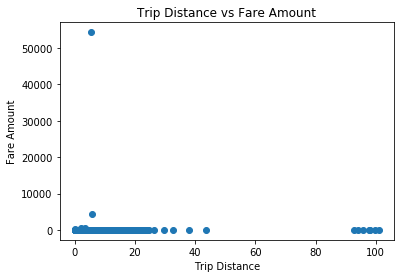

In [30]:
#PLOT TRIP DISTANCE V/S FARE AMOUNT
plt.scatter(x=train['distance_km'],y=train['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")

In [31]:
#closly observing on above plot we observed that some values of fare amount are more than 100$USD for non airport rides this is only possible
#for airport rides in New York. But If they are non-Airport rides than either we have to delete them or impute depending on their importance and no. of such trips
#checking wether they are airport trips.
non_Airport=train.loc[(train['is_dropoff_near_jfk']==False)&(train['is_dropoff_near_lgr']==False)&(train['is_dropoff_near_newark']==False)&(train['is_pickup_near_jfk']==False)&(train['is_pickup_near_lgr']==False)&(train['is_pickup_near_newark']==False)]


Text(0.5, 1.0, 'Trip Distance vs Fare Amount (excluding airport trips)')

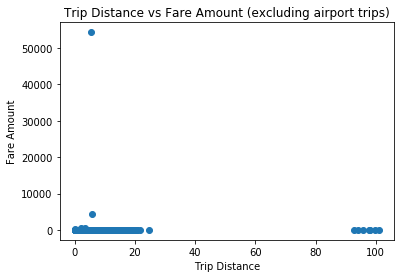

In [32]:
#PLOT FOR TRIP DISTANCE V/S FARE AMOUNT EXCLUDING AIRPORT RIDES
plt.scatter(x=non_Airport['distance_km'],y=non_Airport['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (excluding airport trips)")

In [33]:
#looking on plot of non airport rides, we observed that these high fare rides are city rides and in New York City fare_amount>100$USD is not possible
#because in city fare rides are quite low than airport rides
df=non_Airport[non_Airport.fare_amount>100]
df[['fare_amount','distance_km']]

,fare_amount,distance_km
607,453.0,1.932338
980,434.0,3.295400
1015,54343.0,5.252040
1072,4343.0,5.744321
1483,165.0,0.028498
14142,108.0,3.829811


In [34]:
#these non airport rides with abnormal fares for normal distance should be removed because they are only six such rides and fare_amount for these normal distance rides can be calculated with other available distances
#hence these rides are very less and not important. This clearly states that these are outliers and I decided to remove them.
#remove these abnormal values
non_Airport=non_Airport.drop(non_Airport[non_Airport['fare_amount']>100].index)
train=train.drop(df.index)
non_Airport.shape,train.shape

((14791, 20), (15704, 20))

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (excluding airport trips)')

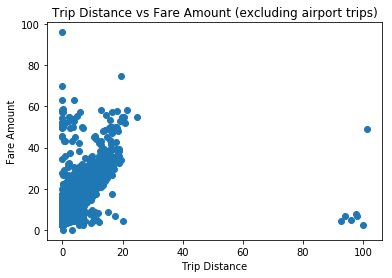

In [35]:
#TRIP DISTANCE V/S FARE AMOUNT OF NON AIRPORT RIDES AFTER REMOVING ABNORMAL VALUES
plt.scatter(x=non_Airport['distance_km'],y=non_Airport['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (excluding airport trips)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

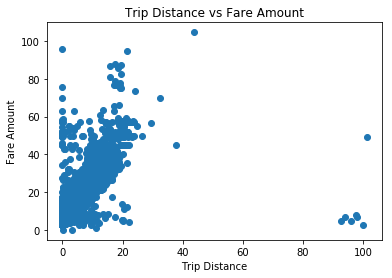

In [36]:
#TRIP DISTANCE V/S FARE AMOUNT OF ALL RIDES AFTER REMOVING ABNORMAL VALUES
plt.scatter(x=train['distance_km'],y=train['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")

In [37]:
#OBSERVING PLOTS WE OBSERVE SOME RIDES WITH HIGHER DISTANCE AND VERY LESS FARES.
non_Airport_long_trips=non_Airport[non_Airport['distance_km']>=80]
non_Airport_long_trips=non_Airport_long_trips[non_Airport_long_trips['fare_amount']<=20]


In [38]:
non_Airport_long_trips[['fare_amount','distance_km','pickup_datetime']]

,fare_amount,distance_km,pickup_datetime
1684,2.5,99.802900,2009-05-02 19:01:01+00:00
3075,6.9,98.015848,2009-01-06 10:53:36+00:00
4487,4.9,95.882126,2009-08-26 07:43:16+00:00
7401,4.5,92.634919,2009-07-16 09:41:26+00:00
9808,6.9,93.955084,2009-08-13 23:15:28+00:00
9899,7.7,97.701251,2009-08-12 19:04:53+00:00


In [39]:
non_Airport_long_trips.index

Int64Index([1684, 3075, 4487, 7401, 9808, 9899], dtype='int64')

In [40]:
#clearly from above two plots we can observe that there are airport some rides with higher and almost same fare_amount
#also there are some non airport rides with trip distance>80km and having very less fare_amount
#these are probably discounted trips by company. In Our hypothesis set we donot make any assumption about discount scheme.
#still Iam observing for other factors like special place, month and special occations these points are very less that a firm result cannot be made.  
#concluding to remove them from data. 
#remove rides with distance_km>80 and fare_amount<20$USD
train.drop(non_Airport_long_trips.index,inplace=True)

In [41]:
train.shape

(15698, 20)

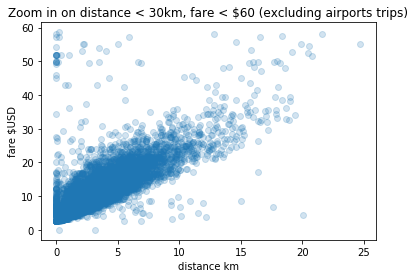

In [42]:
#non airports trips greater than less than 30km 
idx = (non_Airport.distance_km < 30) & (non_Airport.fare_amount < 60)
plt.scatter(non_Airport[idx].distance_km, non_Airport[idx].fare_amount, alpha=0.2)
plt.xlabel('distance km')
plt.ylabel('fare $USD')
plt.title('Zoom in on distance < 30km, fare < $60 (excluding airports trips)');

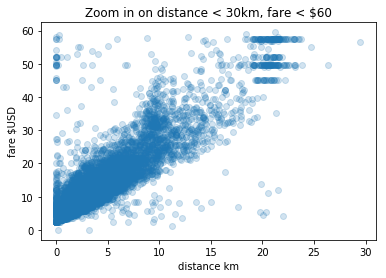

In [43]:
#trips greater than less than 30km 
idx = (train.distance_km < 30) & (train.fare_amount < 60)
plt.scatter(train[idx].distance_km, train[idx].fare_amount, alpha=0.2)
plt.xlabel('distance km')
plt.ylabel('fare $USD')
plt.title('Zoom in on distance < 30km, fare < $60');

WE CAN CLEARLY SEE THE CONSTANT AND LARGE FARES FOR AIRPORT RIDES

In [44]:
#TREATMENT OF passenger_count 
#a normal cab company has minimum 1 and maximum 6 passengers in ride.# same here.
#but according to our hypothesis set fare_amount does not depends on shared rides.
#thus it is better to remove passenger count
del train['passenger_count']

In [45]:
#CONSIDERING CITY BOROUGHS IN MIND
#5 city borughs
#New York city is divided into 5 Boroughs. Let us calculate which borough pickup and dropoff points are. And whether that effects the fare
#New York City encompasses five county-level administrative divisions called boroughs: The Bronx, Brooklyn, Manhattan, Queens, and Staten Island
city_boroughs={
    'manhattan':{
        'min_lng':-74.0479,
        'min_lat':40.6829,
        'max_lng':-73.9067,
        'max_lat':40.8820
    },
    
    'queens':{
        'min_lng':-73.9630,
        'min_lat':40.5431,
        'max_lng':-73.7004,
        'max_lat':40.8007

    },

    'brooklyn':{
        'min_lng':-74.0421,
        'min_lat':40.5707,
        'max_lng':-73.8334,
        'max_lat':40.7395

    },

    'bronx':{
        'min_lng':-73.9339,
        'min_lat':40.7855,
        'max_lng':-73.7654,
        'max_lat':40.9176

    },

    'staten_island':{
        'min_lng':-74.2558,
        'min_lat':40.4960,
        'max_lng':-74.0522,
        'max_lat':40.6490

    }
    
    
    
}

In [46]:
def getBorough(lat,lng):
    
    locs=city_boroughs.keys()
    for loc in locs:
        if lat>=city_boroughs[loc]['min_lat'] and lat<=city_boroughs[loc]['max_lat'] and lng>=city_boroughs[loc]['min_lng'] and lng<=city_boroughs[loc]['max_lng']:
            return loc
    return 'others'

In [47]:
train['pickup_borough']=train.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
train['dropoff_borough']=train.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

Text(0.5, 1.0, 'Distribution of Pickup Boroughs')

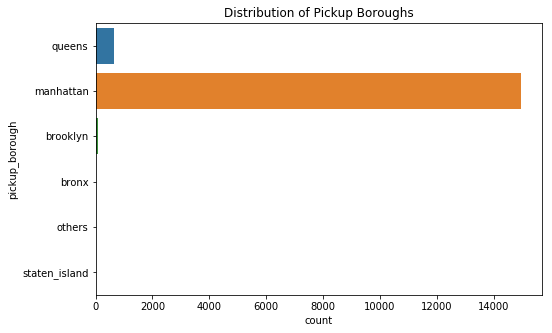

In [48]:
#DISTRIBUTION OF FREQUENCY COUNT FOR BOROUGHS
plt.figure(figsize=(8,5))
sns.countplot(y=train['pickup_borough'])
plt.title("Distribution of Pickup Boroughs")

Text(0.5, 1.0, 'Distribution of Dropofff Boroughs')

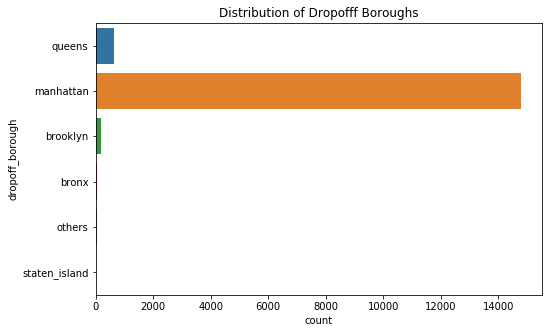

In [49]:
plt.figure(figsize=(8,5))
sns.countplot(y=train['dropoff_borough'])
plt.title("Distribution of Dropofff Boroughs")

C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


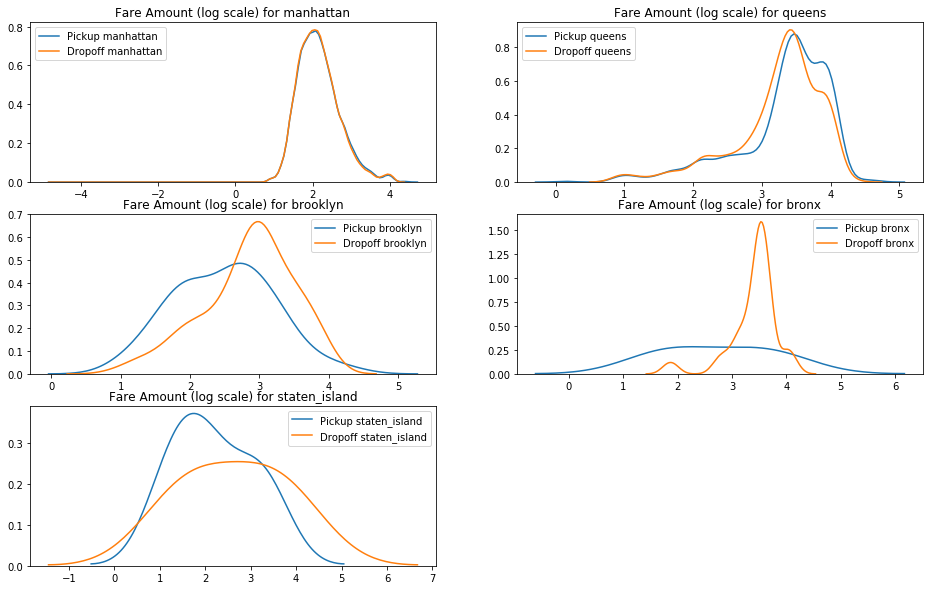

In [50]:
#kdes for distribution of fare amount in pickup and dropoff boroughs
plt.figure(figsize=(16,10))
plt.title("Distribution of Fare Amount Across Boroughs")
i=1
for key in city_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['pickup_borough']==key,'fare_amount'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(train.loc[train['dropoff_borough']==key,'fare_amount'].values),label='Dropoff '+ key).set_title("Fare Amount (log scale) for "+key)
    
    i=i+1

There is a significant difference in pickups and dropoffs fare amount for each burough exceept Manhattan.

C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


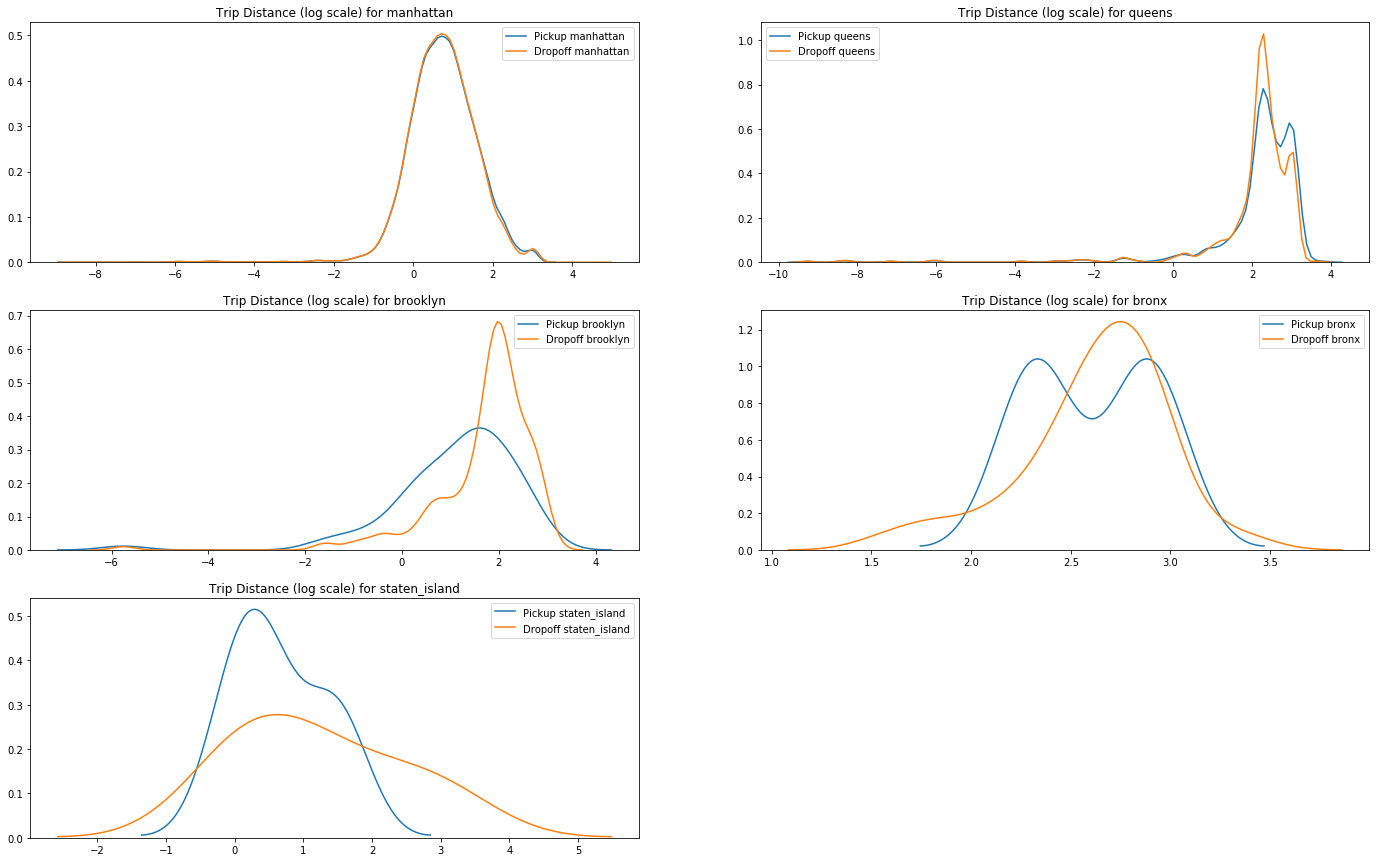

In [51]:
#kdes for distribution of Trip Distance in pickup and dropoff boroughs
plt.figure(figsize=(24,15))
plt.title("Distribution of Trip Distances Across Buroughs")
i=1
for key in city_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['pickup_borough']==key,'distance_km'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(train.loc[train['dropoff_borough']==key,'distance_km'].values),label='Dropoff '+ key).set_title("Trip Distance (log scale) for "+key)
   
    i=i+1

Dropoffs to Bronx are long trips.

Text(0.5, 1.0, 'Distribution of number of trips with pickup year')

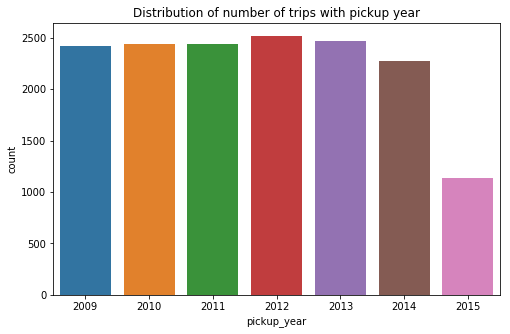

In [52]:
#PLOTS FOR TRIP COUNTS AND AVERAGE FARE OVER YEARS, MONTHS, DAYS, WEEKDAYS, 
#no. of trips with year
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_year'])
plt.title("Distribution of number of trips with pickup year")

Text(0.5, 1.0, 'Avg Fare Amount over Years')

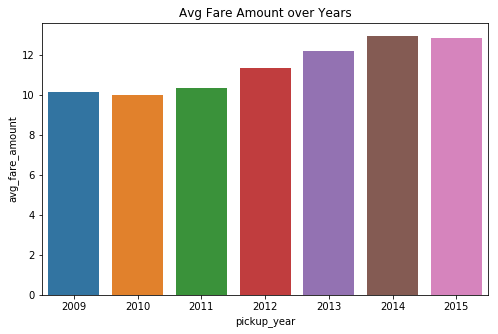

In [53]:
#avg fare amount over year
trips_year_fareamount=train.groupby(['pickup_year'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_year',y='avg_fare_amount',data=trips_year_fareamount).set_title("Avg Fare Amount over Years")

Text(0.5, 1.0, 'Distribution of number of trips with pickup month')

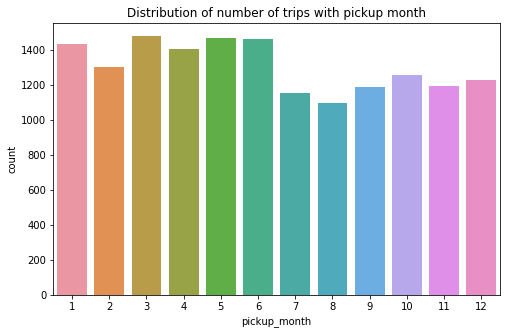

In [54]:
#no. of trips with month
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_month'])
plt.title("Distribution of number of trips with pickup month")

Text(0.5, 1.0, 'Avg Fare Amount over month')

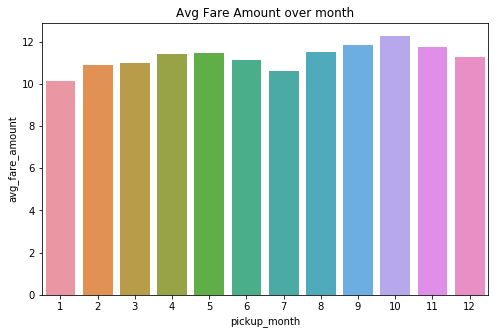

In [55]:
#avg fare amount over month
trips_month_fareamount=train.groupby(['pickup_month'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_month',y='avg_fare_amount',data=trips_month_fareamount).set_title("Avg Fare Amount over month")

Text(0.5, 1.0, 'Distribution of number of trips with pickup day')

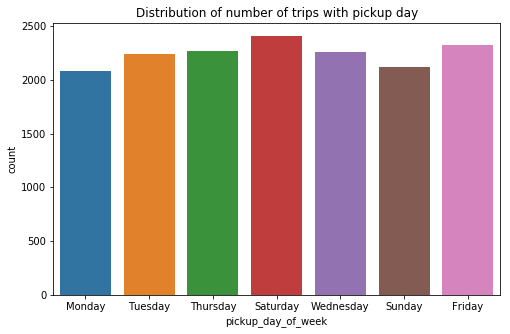

In [56]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_day_of_week'])
plt.title("Distribution of number of trips with pickup day")

Text(0.5, 1.0, 'Avg Fare Amount over days')

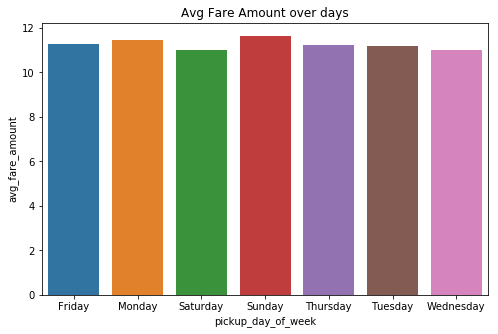

In [57]:
trips_day_fareamount=train.groupby(['pickup_day_of_week'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week',y='avg_fare_amount',data=trips_day_fareamount).set_title("Avg Fare Amount over days")

Text(0.5, 1.0, 'Distribution of number of trips with pickup hour')

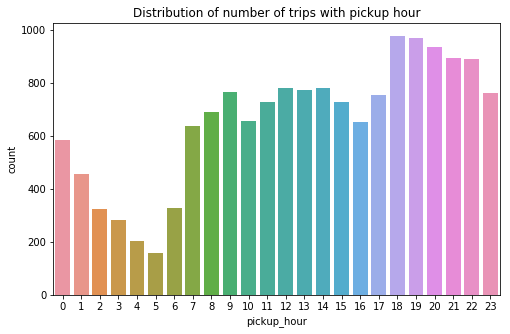

In [58]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour'])
plt.title("Distribution of number of trips with pickup hour")

Text(0.5, 1.0, 'Avg Fare Amount over hours')

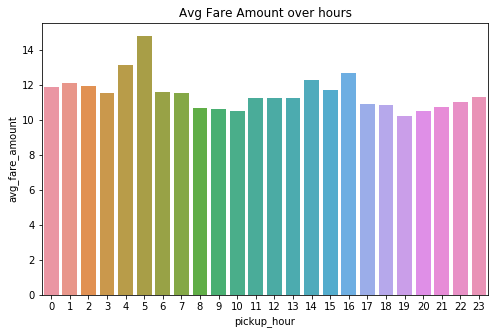

In [59]:
trips_hour_fareamount=train.groupby(['pickup_hour'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_hour',y='avg_fare_amount',data=trips_hour_fareamount).set_title("Avg Fare Amount over hours")

In [60]:
# Let us encode day of the week to numbers
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]
train['pickup_day_of_week']=train['pickup_day_of_week'].apply(lambda x:encodeDays(x))

In [61]:
train.shape

(15698, 21)

In [62]:
#save above changes
train.to_csv("cleaned_train.csv",index=False)

In [63]:
#featuring in test data
test.dtypes

pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [64]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'])
test.dtypes

pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [65]:
def is_pickup_near_Airport_test(loc,range=2.5):
    return(distance(test.pickup_latitude, test.pickup_longitude, loc[1], loc[0]) < range)
      
   
def is_dropoff_near_Airport_test(loc,range=2.5):
    return(distance(test.dropoff_latitude, test.dropoff_longitude, loc[1], loc[0]) < range)
     

In [66]:
test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_month']=test['pickup_datetime'].apply(lambda x:x.month)
test['pickup_year']=test['pickup_datetime'].apply(lambda x:x.year)
test['pickup_day_of_week']=test['pickup_day_of_week'].apply(lambda x:encodeDays(x))
test['distance_km'] = distance(test.pickup_latitude, test.pickup_longitude,test.dropoff_latitude, test.dropoff_longitude)
test['pickup_borough']=test.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
test['dropoff_borough']=test.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
test['is_pickup_near_jfk']=is_pickup_near_Airport_test(jfk)
test['is_dropoff_near_jfk']=is_dropoff_near_Airport_test(jfk)
test['is_pickup_near_lgr']=is_pickup_near_Airport_test(lgr)
test['is_dropoff_near_lgr']=is_dropoff_near_Airport_test(lgr)
test['is_pickup_near_newark']=is_pickup_near_Airport_test(ewr)
test['is_dropoff_near_newark']=is_dropoff_near_Airport_test(ewr)

In [67]:
#remove passenger_count from test
del test['passenger_count']

In [68]:
test.shape

(9914, 20)

In [69]:
test.to_csv("cleaned_test.csv",index=False)

In [70]:
#Here our part one of exploratory analysis and data cleaning is completed.
#Next part will be of feature engineering and data modelling.